In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os 
import tensorflow as tf

# keras module for building LSTM 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
!pip install tensorflow==2.4.0

In [9]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
# data file
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/lyrics_gen/lyrics-dataset.csv')
df.head()

,ALink,SName,SLink,Lyric,Idiom
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH


In [11]:
df.drop(['ALink','SName','SLink'],axis=1,inplace=True)

In [12]:
# english songs only
df = df[df['Idiom']=='ENGLISH']

In [13]:
df.shape

(114723, 2)

In [14]:
df = df[:80]
df.shape

(80, 2)

In [15]:
df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))
df.head()

,Lyric,Idiom,Number_of_words
0,I could feel at the time. There was no way of ...,ENGLISH,145
1,"Take me now, baby, here as I am. Hold me close...",ENGLISH,238
2,These are. These are days you'll remember. Nev...,ENGLISH,172
3,"A lie to say, ""O my mountain has coal veins an...",ENGLISH,263
4,Trudging slowly over wet sand. Back to the ben...,ENGLISH,118


In [16]:
df['Number_of_words'].describe()

count     80.000000
mean     196.850000
std       69.531361
min       66.000000
25%      145.000000
50%      186.000000
75%      246.000000
max      415.000000
Name: Number_of_words, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

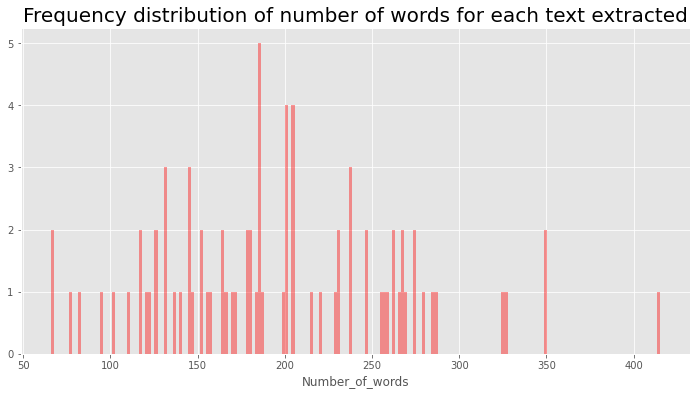

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

In [18]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(df['Lyric'].astype(str))
tokenized_sentences[0]

[5,
 60,
 134,
 62,
 1,
 50,
 51,
 18,
 25,
 86,
 8,
 417,
 418,
 654,
 7,
 1,
 44,
 71,
 32,
 54,
 57,
 278,
 419,
 24,
 210,
 24,
 1,
 279,
 1511,
 900,
 188,
 1,
 189,
 16,
 1,
 245,
 141,
 25,
 86,
 8,
 655,
 82,
 106,
 41,
 6,
 33,
 78,
 160,
 82,
 106,
 41,
 87,
 11,
 52,
 507,
 82,
 106,
 41,
 6,
 33,
 78,
 160,
 15,
 18,
 656,
 9,
 2,
 211,
 51,
 18,
 25,
 86,
 8,
 417,
 35,
 2,
 344,
 7,
 1,
 44,
 71,
 32,
 54,
 57,
 345,
 420,
 25,
 246,
 7,
 1,
 83,
 346,
 47,
 900,
 188,
 1,
 189,
 16,
 1,
 245,
 141,
 25,
 86,
 8,
 655,
 82,
 106,
 41,
 6,
 33,
 78,
 160,
 82,
 106,
 41,
 87,
 11,
 52,
 507,
 82,
 106,
 41,
 6,
 33,
 78,
 160,
 82,
 106,
 41,
 6,
 33,
 78,
 160,
 82,
 106,
 41,
 87,
 11,
 52,
 507,
 82,
 106,
 41,
 78,
 160]

In [19]:
# Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [20]:
# create predictors and label
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [71]:
# create model
from tensorflow.keras import regularizers
model = tf.keras.Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_len-1))# Embedding Layer
model.add(Bidirectional(LSTM(250, return_sequences = True)))# An LSTM Layer
model.add(Dropout(0.2))# A dropout layer
model.add(LSTM(100))# Another LSTM Layer
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))# A Dense Layer including regularizers
model.add(Dense(total_words, activation='softmax'))# A Dense Layer)
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])# Pick a loss function and an optimizer
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 415, 50)           132100    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 415, 500)          602000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 415, 500)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dense_8 (Dense)              (None, 1321)              133421    
_________________________________________________________________
dense_9 (Dense)              (None, 2642)              3492724   
Total params: 4,600,645
Trainable params: 4,600,645
Non-trainable params: 0
____________________________________________

In [72]:
history = model.fit(X, y, epochs=100, verbose=1, callbacks=[earlystop])

Epoch 1/100
489/489 [==============================] - 149s 294ms/step - loss: 6.6995 - accuracy: 0.0490
Epoch 2/100
489/489 [==============================] - 143s 293ms/step - loss: 6.2128 - accuracy: 0.0519
Epoch 3/100
489/489 [==============================] - 143s 293ms/step - loss: 6.0544 - accuracy: 0.0525
Epoch 4/100
489/489 [==============================] - 144s 294ms/step - loss: 5.9434 - accuracy: 0.0540
Epoch 5/100
489/489 [==============================] - 143s 293ms/step - loss: 5.8336 - accuracy: 0.0567
Epoch 6/100
489/489 [==============================] - 143s 293ms/step - loss: 5.7209 - accuracy: 0.0603
Epoch 7/100
489/489 [==============================] - 143s 293ms/step - loss: 5.5962 - accuracy: 0.0672
Epoch 8/100
489/489 [==============================] - 143s 293ms/step - loss: 5.4845 - accuracy: 0.0782
Epoch 9/100
489/489 [==============================] - 144s 294ms/step - loss: 5.3885 - accuracy: 0.0864
Epoch 10/100
489/489 [==============================] -

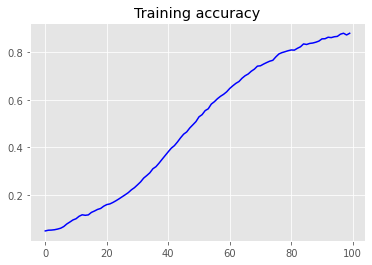

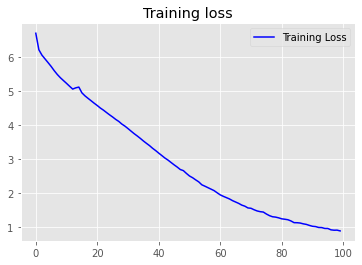

In [73]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [96]:
# save model
from tensorflow.keras.models import load_model
model.save('/content/gdrive/My Drive/Colab Notebooks/lyrics_gen/song_lyrics_generator.h5')

In [4]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/lyrics_gen/song_lyrics_generator.h5')

In [29]:
def generate_lyrics(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [32]:
# import warnings
# warnings.filterwarnings('ignore')

In [33]:
generate_lyrics("The sun is the same in a relative way but you're older", 40)

"The sun is the same in a relative way but you're older in game how i wish i knew dallas as a circle i dreamed of a circle round and in that circle i could see into all a circle i dreamed of a circle round and in that circle i could see into all a circle i dreamed of a circle round and in that circle i could see into all a circle i dreamed of a circle round and in that circle i could see into all a circle i dreamed of a circle round and in that circle i could see into all a circle i dreamed of a circle round and in that circle i could see into all a circle i dreamed of a circle round and in that circle i could see into all a circle i dreamed of a circle round and in that circle"

In [34]:
generate_lyrics("When I was a child", 100)

"When I was a child that the man who's wanna turn it but above music will see amuse you'd go anything oh somewhere in disguise a boy in the dark voice you're dragging from powdered soils and cry no second placers no smart looking geese in bonnets dance with pigs in high button trousers no milk pail for the city me and loretta liked an ocean tide and young girl in a comical where's the end parade of the sort people here would think unusual jenny tonight upon the mock brine of a luna sea far off we sail on to back o' the moon"

In [35]:
generate_lyrics("I don't love you", 150)

"I don't love you before you back up in the sort people here would think unusual jenny tonight upon the mock brine of a luna sea far off we sail on to the demented choirs the wailing of shells the boys holding candles on untraveled roads the boys are starting in the dawning tell me the part that shines in your heart and the rays of love forever please take me there as how like well a saint they made you you're just like mary down in mexico on all souls' day you chose your words from mouths of babes lost in the world the cool junk booting madmen street minded girls in harlem howling at night what a tear stained shock of the world you've gone away without saying goodbye by the cemetery ground as we god's acre is a fenced in hollow ground here soon to rise up amelia tender and sweet"

In [36]:
generate_lyrics("You shall go where I cannot", 60)

"You shall go where I cannot read to show this lonesome shall spaces like so no jack or kill what their feet come her fingers she overturned it considered planting some flowers they wouldn't last long no one to tend them it's funny how these things go you were the sun well the bodies wracked while their lots and you can cut the dread and oftimes"

In [37]:
generate_lyrics("The is the end", 100)

"The is the end lost on a berry that grown you close my man was not with minds that earn degrees the air tossing back more than your share you talk talk talk about it you talk as if you care i'm marking every word and can tell this time for sure your talk is the finest i have heard so don't talk i'll be sleeping let me go on dreaming how your eyes they glow so fiercely i can tell your inspired by the name you just chose for me now what was it o never mind it we will talk talk talk"